In [5]:
import os
import json
import matplotlib.pyplot as plt
import re
import matplotlib.pyplot as plt
import seaborn as sns

#### Accuracy Training

In [6]:
def concat_metrics(folder_path: str):
    merged_data = {}

    for file in os.listdir(folder_path):
        if file.endswith('.json'):
            with open(os.path.join(folder_path, file), 'r') as f:
                data = json.load(f)
                merged_data.update(data)

    return merged_data

def plot_accuracy(folder_path, title):
    data = concat_metrics(folder_path)

    # Sort by numeric keys
    keys = sorted(data.keys(), key=lambda x: int(x))

    # Extract accuracies
    model_accuracies = [data[k].get('model_accuracy', 0) for k in keys]
    circuit_accuracies = [data[k].get('graph_accuracy', 0) for k in keys]

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(keys, model_accuracies, marker='o', label='Model Accuracy')
    plt.plot(keys, circuit_accuracies, marker='s', label='Circuit (Graph) Accuracy', linestyle='--')

    plt.xlabel('Run ID')
    plt.ylabel('Accuracy')
    plt.title(f'Model vs Circuit Accuracy Across Runs:{title}')
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_faithfulness(folder_path, title):
    data = concat_metrics(folder_path)

    # Sort by numeric keys
    keys = sorted(data.keys(), key=lambda x: int(x))

    # Extract accuracies
    model_accuracies = [data[k].get('percentage_performance_kl', 0) for k in keys]

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(keys, model_accuracies, marker='o', label='Model Accuracy')

    plt.xlabel('Run ID')
    plt.ylabel('Accuracy')
    plt.title(f'Model vs Circuit Accuracy Across Runs:{title}')
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [3]:
import matplotlib.pyplot as plt
import itertools

def plot_accuracy(folder_paths, titles=None):
    if isinstance(folder_paths, str):
        folder_paths = [folder_paths]

    if titles is None:
        titles = [f'Run {i}' for i in range(len(folder_paths))]

    plt.figure(figsize=(10, 6))
    
    # Color cycle
    colors = itertools.cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

    for folder_path, title in zip(folder_paths, titles):
        data = concat_metrics(folder_path)
        keys = sorted(data.keys(), key=lambda x: int(x))

        model_accuracies = [data[k].get('model_accuracy', 0) for k in keys]
        circuit_accuracies = [data[k].get('graph_accuracy', 0) for k in keys]

        color = next(colors)

        plt.plot(keys, model_accuracies, marker='o', label=f'{title} - Model', color=color)
        plt.plot(keys, circuit_accuracies, marker='s', linestyle='--', label=f'{title} - Circuit', color=color)

    plt.xlabel('Run ID')
    plt.ylabel('Accuracy')
    plt.title('Model vs Circuit Accuracy Across Runs')
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [15]:
paths = ['../circuit-gen/two-digit-arithmetic_run_2007/addsub_inverse/metrics','../circuit-gen/two-digit-arithmetic_run_2007/addsub/metrics', '../circuit-gen/two-digit-arithmetic_run_2007/new-zarp/metrics']

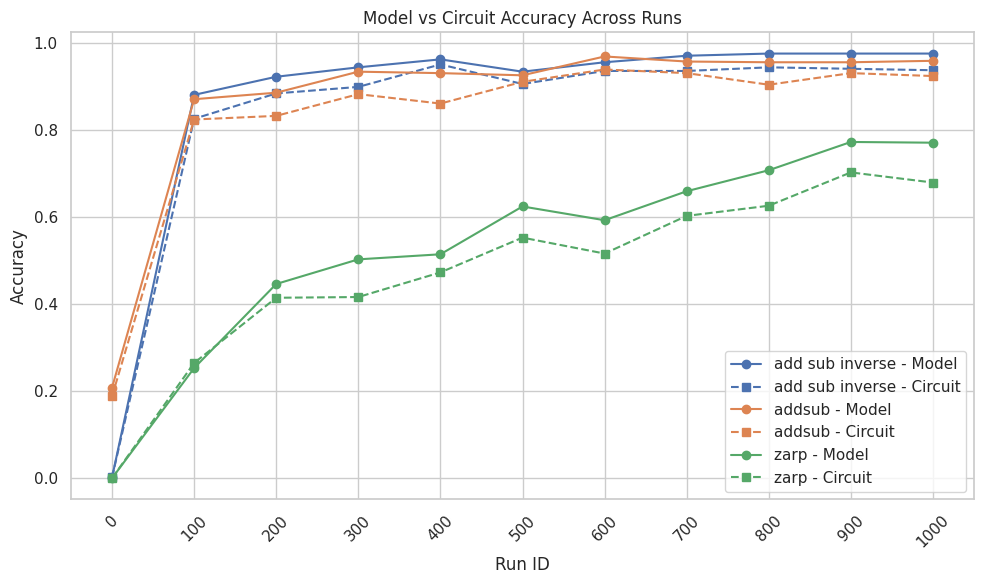

In [17]:
plot_accuracy(paths, ['add sub inverse', 'addsub', 'zarp'])

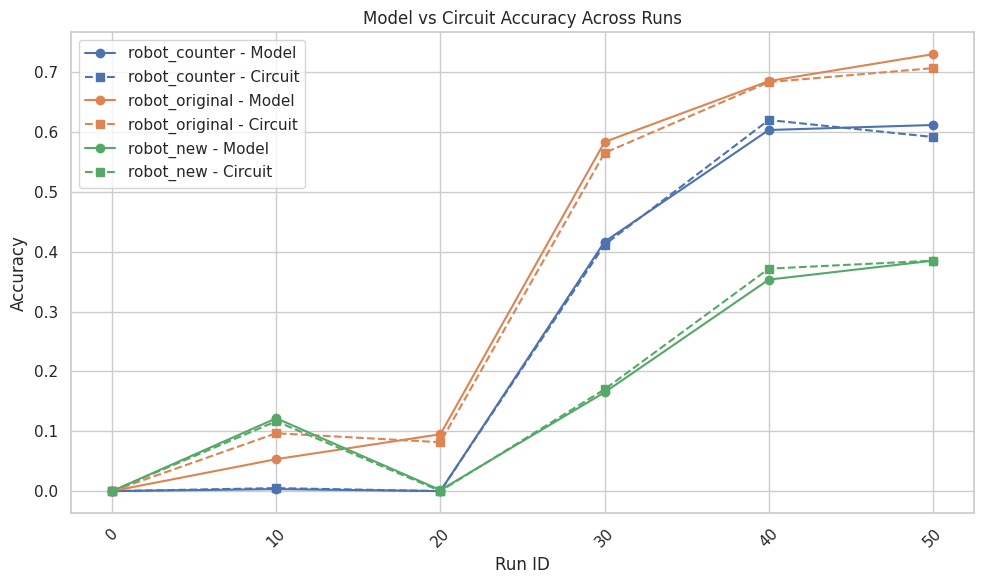

In [20]:
paths = ['../circuit-gen/robot/robot_counter/metrics','../circuit-gen/robot/robot_original/metrics', '../circuit-gen/robot/robot_new/metrics']
plot_accuracy(paths, ['robot_counter', 'robot_original', 'robot_new'])

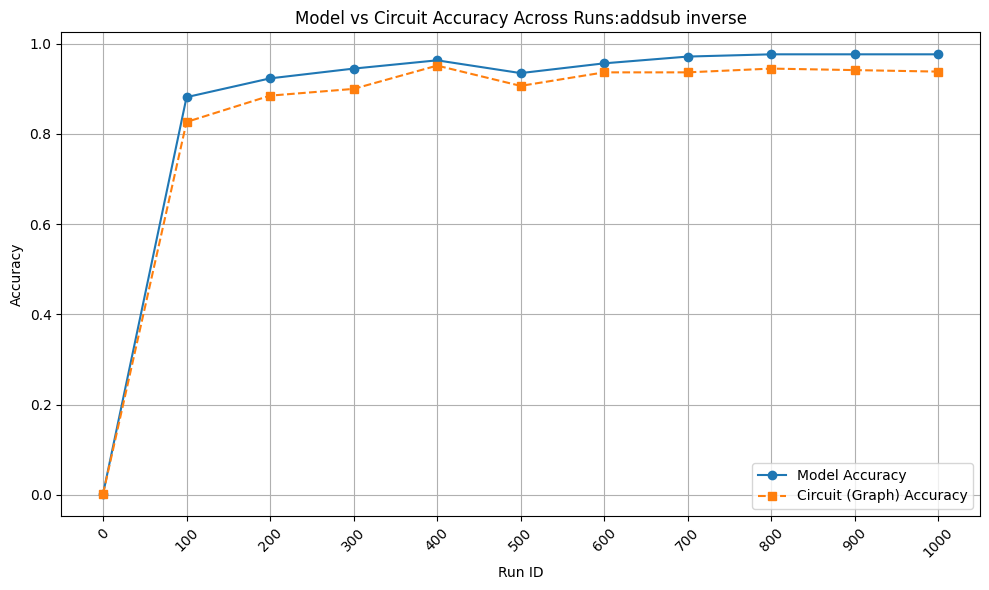

In [5]:
path = '../circuit-gen/two-digit-arithmetic_run_2007/addsub_inverse/metrics'
plot_accuracy(path, 'addsub inverse')

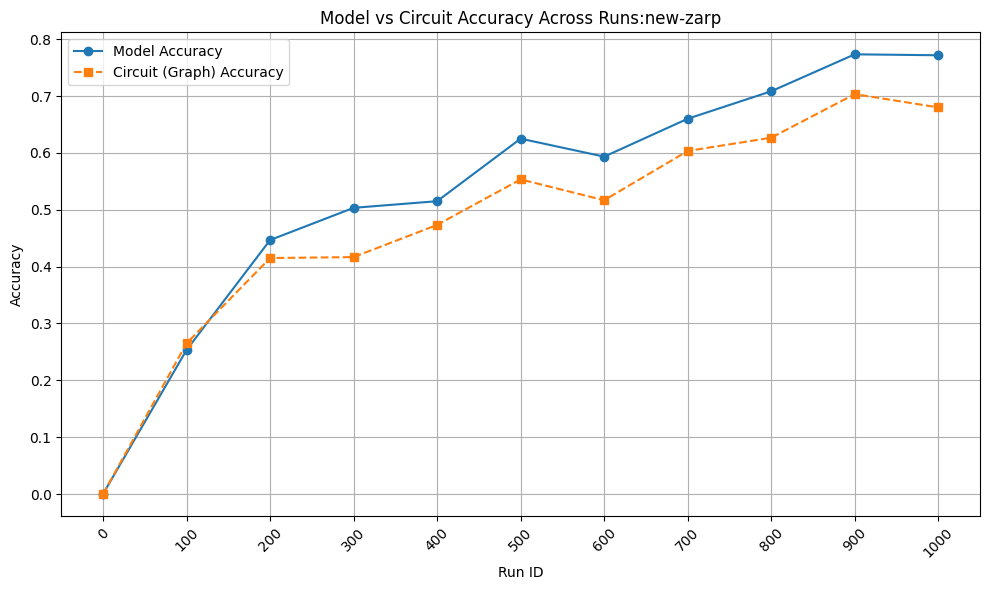

In [6]:
path = '../circuit-gen/two-digit-arithmetic_run_2007/new-zarp/metrics'
plot_accuracy(path, 'new-zarp')

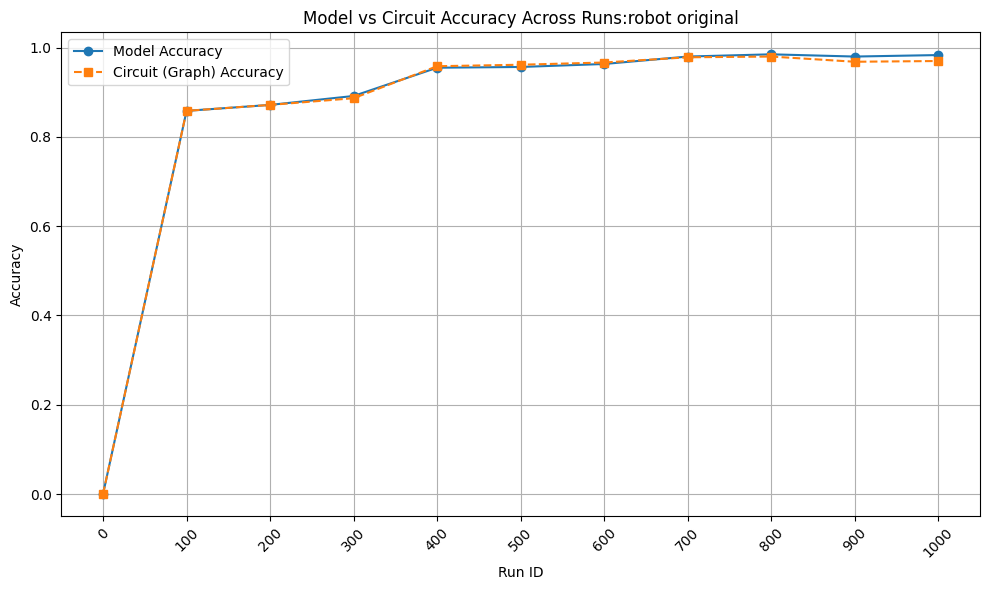

In [8]:
path = '../circuit-gen/robot_run_2007/robot_original/metrics'
plot_accuracy(path,'robot original')

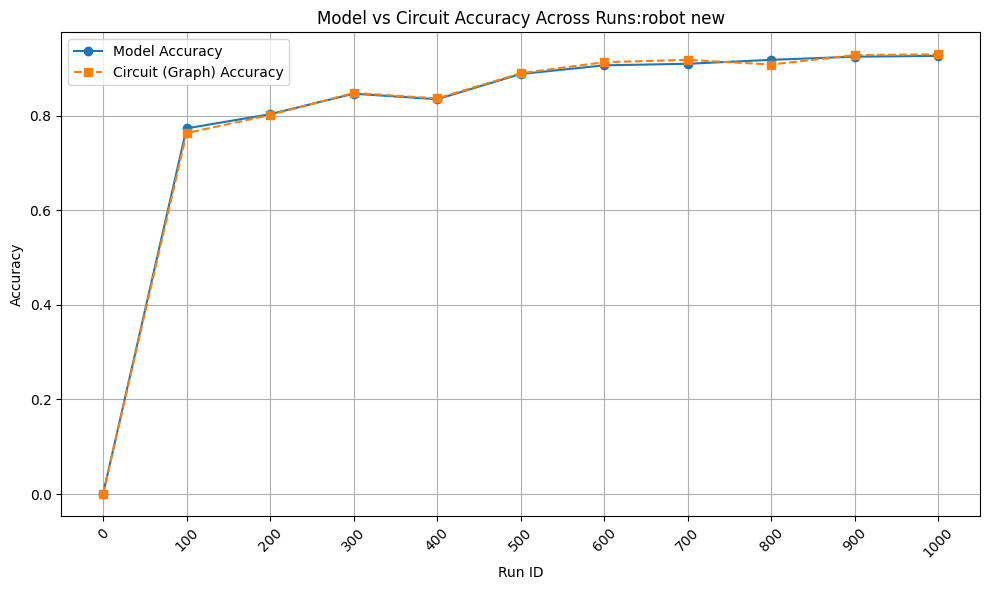

In [9]:
path = '../circuit-gen/robot_run_2007/robot_new/metrics'
plot_accuracy(path, 'robot new')

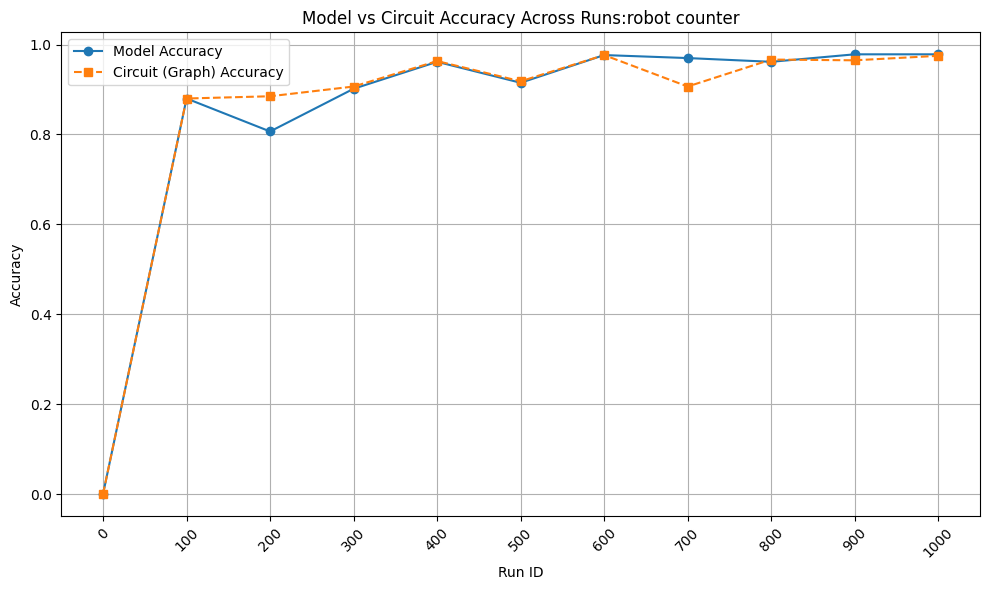

In [10]:
path = '../circuit-gen/robot_run_2007/robot_counter/metrics'
plot_accuracy(path, 'robot counter')

In [4]:
def load_checkpoints_in_order(task_dir):
    checkpoints = []
    files = [f for f in os.listdir(task_dir) if f.endswith('.json')]

    checkpoint_files = []
    for filename in files:
        match = re.search(r'graph_(\d+)\.json', filename)
        if match:
            num = int(match.group(1))
            checkpoint_files.append((num, filename))

    checkpoint_files.sort(key=lambda x: x[0])

    for _, filename in checkpoint_files:
        checkpoint_path = os.path.join(task_dir, filename)
        with open(checkpoint_path, 'r') as f:
            data = json.load(f)
            checkpoints.append(data)

    return checkpoints

In [14]:
import math
import numpy as np

def count_nodes_per_checkpoint(checkpoints):
    node_counts = []
    for checkpoint in checkpoints:
        nodes = checkpoint['nodes']
        true_count = sum(1 for node, state in nodes.items() if state)
        node_counts.append(true_count)
    return node_counts

def calculate_node_changes(checkpoints):
    changes = []
    for i in range(1, len(checkpoints)):
        prev_nodes = checkpoints[i - 1]['nodes']
        curr_nodes = checkpoints[i]['nodes']
        added = sum(
            1 for node in curr_nodes
            if curr_nodes[node].get('in_graph', False) and not prev_nodes.get(node, {}).get('in_graph', False)
        )       

        removed = sum(
            1 for node in prev_nodes
            if prev_nodes[node].get('in_graph', False) and not curr_nodes.get(node, {}).get('in_graph', False)
        )
        changes.append(added + removed)

    return changes

def calculate_edge_changes_top_5_percent(checkpoints):
    changes = []

    for i in range(1, len(checkpoints)):
        prev_edges = checkpoints[i - 1].get('edges', {})
        curr_edges = checkpoints[i].get('edges', {})

        prev_sorted = sorted(
            [(e, abs(v['score'])) for e, v in prev_edges.items() if v],
            key=lambda x: x[1],
            reverse=True
        )
        curr_sorted = sorted(
            [(e, abs(v['score'])) for e, v in curr_edges.items() if v],
            key=lambda x: x[1],
            reverse=True
        )

        prev_k = math.ceil(0.05 * len(prev_sorted))
        curr_k = math.ceil(0.05 * len(curr_sorted))

        prev_high_edges = set(e for e, _ in prev_sorted[:prev_k])
        curr_high_edges = set(e for e, _ in curr_sorted[:curr_k])

        changed_edges = prev_high_edges.symmetric_difference(curr_high_edges)

        print(f"Step {i} -- Prev top-k: {prev_k}, Curr top-k: {curr_k}, Changes: {len(changed_edges)}")
        changes.append(len(changed_edges))
    return changes


def calculate_edge_changes_top_95_percent(checkpoints):
    changes = []

    for i in range(1, len(checkpoints)):
        prev_edges = checkpoints[i - 1].get('edges', {})
        curr_edges = checkpoints[i].get('edges', {})

        prev_scores = [abs(v['score']) for v in prev_edges.values() if v]
        curr_scores = [abs(v['score']) for v in curr_edges.values() if v]

        prev_threshold = np.percentile(prev_scores, 95) if prev_scores else 0
        curr_threshold = np.percentile(curr_scores, 95) if curr_scores else 0

        # Select edges with scores >= threshold
        prev_high_edges = set(e for e, v in prev_edges.items() if v and abs(v['score']) >= prev_threshold)
        curr_high_edges = set(e for e, v in curr_edges.items() if v and abs(v['score']) >= curr_threshold)

        changed_edges = prev_high_edges.symmetric_difference(curr_high_edges)
        print(f"Step {i} -- Prev threshold: {prev_threshold}, Curr threshold: {curr_threshold}, Changes: {len(changed_edges)}")
        changes.append(len(changed_edges))

    return changes

def calculate_delta_S(total_dir):
    checkpoints = load_checkpoints_in_order(total_dir)
    changes = calculate_edge_changes_top_5_percent(checkpoints)

    # Get initial size S0 (number of edges at checkpoint 0)
    initial_edges = checkpoints[0].get('edges', {})
    S0 = len(initial_edges)
    if S0 == 0:
        return 0  # avoid division by zero

    n = len(changes)
    sum_relative_changes = sum(change / S0 for change in changes)

    delta_S = (sum_relative_changes / n) * 100  # percentage
    return delta_S


def visualize_fine_tunings(total_dirs: list, type = 'edges'):
    sns.set_theme(style="whitegrid")

    plt.figure(figsize=(10, 5))
    labels = []

    for total_dir in total_dirs:
        checkpoints = load_checkpoints_in_order(total_dir)
        if type == 'nodes': 
            changes = calculate_node_changes(checkpoints)
        else:
            changes = calculate_edge_changes_top_95_percent(checkpoints)

        transitions = range(1, len(changes) + 1)
        label = os.path.basename(os.path.dirname(total_dir.rstrip('/')))
        labels.append(label)

        plt.plot(transitions, changes, marker='o', linestyle='-', label=label)

    plt.xlabel('Checkpoint Transition', fontsize=14)
    plt.ylabel(f'Number of {type} Changes', fontsize=14)
    plt.title(f'{type} changes Between Checkpoints Across Runs', fontsize=16)
    plt.legend(title="Runs", fontsize=10)
    plt.tight_layout()
    plt.grid(True)
    plt.show()

    return labels

Step 1 -- Prev threshold: 6.726978085680458e-10, Curr threshold: 3.734707920699517e-09, Changes: 10904
Step 2 -- Prev threshold: 3.734707920699517e-09, Curr threshold: 2.758118755608052e-09, Changes: 7622
Step 3 -- Prev threshold: 2.758118755608052e-09, Curr threshold: 2.673824672783096e-09, Changes: 4872
Step 4 -- Prev threshold: 2.673824672783096e-09, Curr threshold: 2.5572933992634716e-09, Changes: 3044
Step 5 -- Prev threshold: 2.5572933992634716e-09, Curr threshold: 2.584653557846644e-09, Changes: 1672
Step 1 -- Prev threshold: 7.669825330403046e-10, Curr threshold: 2.399899434735173e-09, Changes: 11450
Step 2 -- Prev threshold: 2.399899434735173e-09, Curr threshold: 2.6890460080863922e-09, Changes: 8526
Step 3 -- Prev threshold: 2.6890460080863922e-09, Curr threshold: 2.6759049642777195e-09, Changes: 5444
Step 4 -- Prev threshold: 2.6759049642777195e-09, Curr threshold: 2.6839196198835672e-09, Changes: 3896
Step 5 -- Prev threshold: 2.6839196198835672e-09, Curr threshold: 2.78442

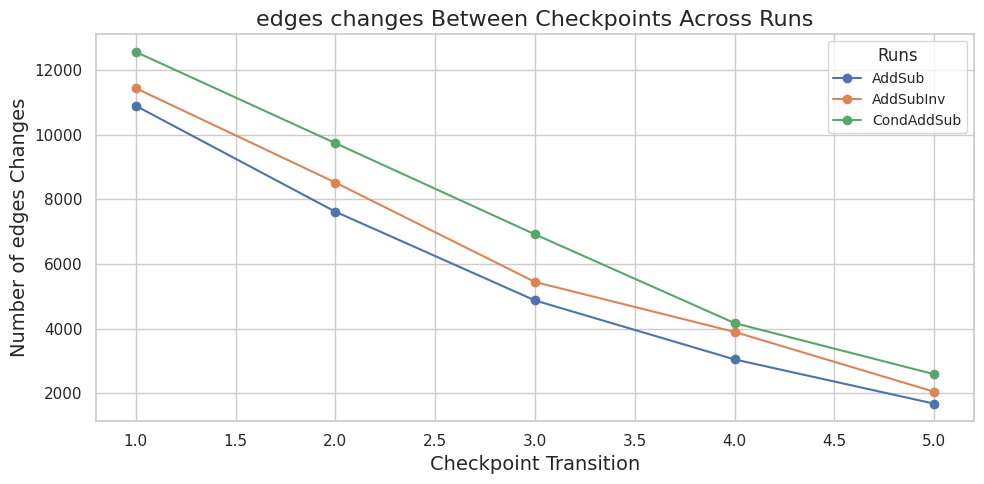

['AddSub', 'AddSubInv', 'CondAddSub']

In [15]:
paths = ['../circuit-gen/two-digit-arithmetic_28/AddSub/graphs', 
         '../circuit-gen/two-digit-arithmetic_28/AddSubInv/graphs',
         '../circuit-gen/two-digit-arithmetic_28/CondAddSub/graphs']
visualize_fine_tunings(paths, type = 'edges')

Step 1 -- Prev threshold: 6.726978085680458e-10, Curr threshold: 3.734707920699517e-09, Changes: 10904
Step 2 -- Prev threshold: 3.734707920699517e-09, Curr threshold: 2.758118755608052e-09, Changes: 7622
Step 3 -- Prev threshold: 2.758118755608052e-09, Curr threshold: 2.673824672783096e-09, Changes: 4872
Step 4 -- Prev threshold: 2.673824672783096e-09, Curr threshold: 2.5572933992634716e-09, Changes: 3044
Step 5 -- Prev threshold: 2.5572933992634716e-09, Curr threshold: 2.584653557846644e-09, Changes: 1672
Step 1 -- Prev threshold: 7.669825330403046e-10, Curr threshold: 2.399899434735173e-09, Changes: 11450
Step 2 -- Prev threshold: 2.399899434735173e-09, Curr threshold: 2.6890460080863922e-09, Changes: 8526
Step 3 -- Prev threshold: 2.6890460080863922e-09, Curr threshold: 2.6759049642777195e-09, Changes: 5444
Step 4 -- Prev threshold: 2.6759049642777195e-09, Curr threshold: 2.6839196198835672e-09, Changes: 3896
Step 5 -- Prev threshold: 2.6839196198835672e-09, Curr threshold: 2.78442

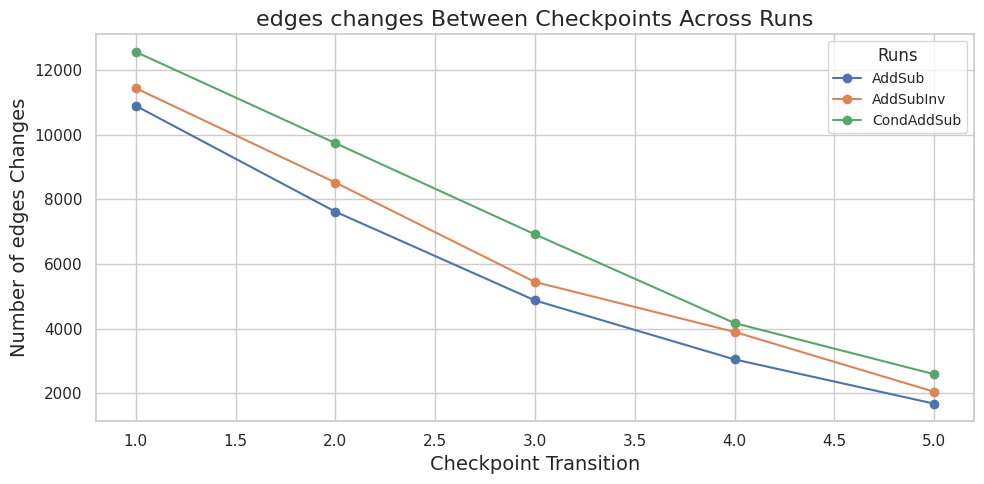

['AddSub', 'AddSubInv', 'CondAddSub']

In [16]:
paths = ['../circuit-gen/two-digit-arithmetic_28/AddSub/graphs', 
         '../circuit-gen/two-digit-arithmetic_28/AddSubInv/graphs',
         '../circuit-gen/two-digit-arithmetic_28/CondAddSub/graphs']
visualize_fine_tunings(paths, type = 'edges')

Step 1 -- Prev threshold: 9.313024684765022e-10, Curr threshold: 1.9662426797850674e-09
Step 2 -- Prev threshold: 1.9662426797850674e-09, Curr threshold: 1.973783136932634e-09
Step 3 -- Prev threshold: 1.973783136932634e-09, Curr threshold: 1.7585161771194155e-09
Step 4 -- Prev threshold: 1.7585161771194155e-09, Curr threshold: 2.0049054416659804e-09
Step 5 -- Prev threshold: 2.0049054416659804e-09, Curr threshold: 1.9810725948588004e-09
Step 1 -- Prev threshold: 7.408782365381226e-10, Curr threshold: 1.9756853042451872e-09
Step 2 -- Prev threshold: 1.9756853042451872e-09, Curr threshold: 1.8005032575985069e-09
Step 3 -- Prev threshold: 1.8005032575985069e-09, Curr threshold: 1.7678549069088943e-09
Step 4 -- Prev threshold: 1.7678549069088943e-09, Curr threshold: 1.9795407091294235e-09
Step 5 -- Prev threshold: 1.9795407091294235e-09, Curr threshold: 2.056304237996184e-09
Step 1 -- Prev threshold: 7.008934432839452e-10, Curr threshold: 2.0229630415258237e-09
Step 2 -- Prev threshold: 2

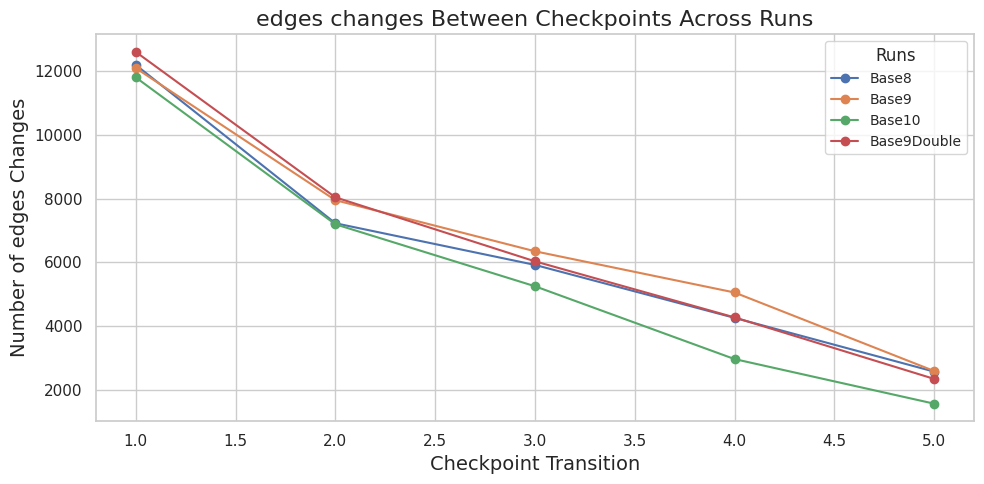

['Base8', 'Base9', 'Base10', 'Base9Double']

In [37]:
visualize_fine_tunings(paths, type = 'edges')

#### 

In [37]:
paths = ['../circuit-gen/results/two-digit-arithmetic/new-zarp/graphs', 
         '../circuit-gen/results/two-digit-arithmetic/addsub/graphs', 
         '../circuit-gen/results/two-digit-arithmetic/addsub_inverse/graphs']

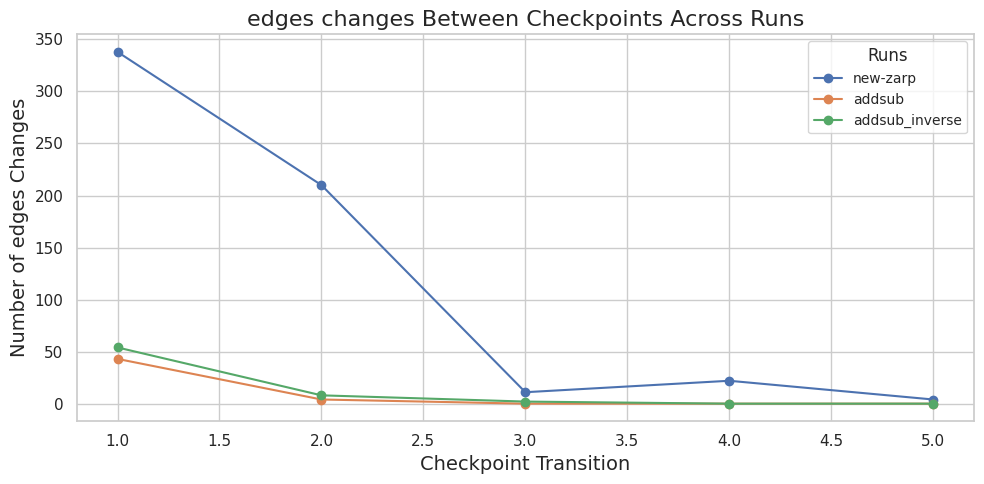

['new-zarp', 'addsub', 'addsub_inverse']

In [ ]:
visualize_fine_tunings(paths, type = 'edges')

In [39]:
robot_paths = ['../circuit-gen/results/robot/robot_counter/graphs', 
               '../circuit-gen/results/robot/robot_new/graphs', 
               '../circuit-gen/results/robot/robot_original/graphs']

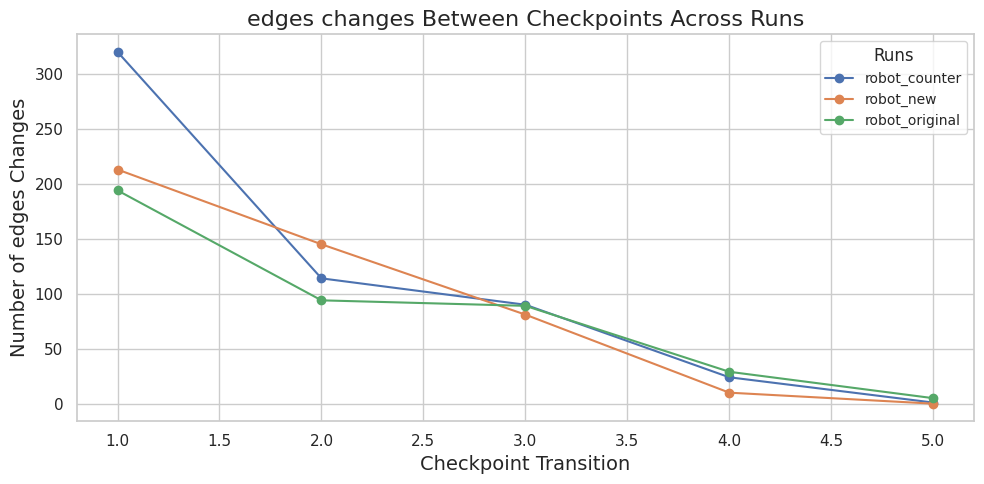

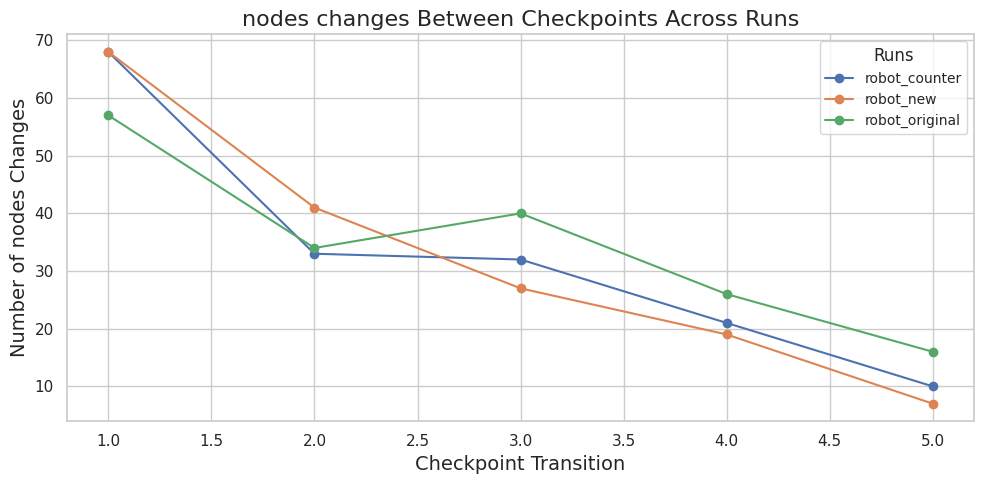

['robot_counter', 'robot_new', 'robot_original']

In [40]:
visualize_fine_tunings(robot_paths, type = 'edges')
visualize_fine_tunings(robot_paths, type = 'nodes')

In [1]:
addsub_paths = ['../old-fine-tunng/sequential-fine-tuning/experiment_1/circuit_metrics/addsub/graphs']

In [2]:
visualize_fine_tunings(addsub_paths, type = 'edges')
visualize_fine_tunings(addsub_paths, type = 'nodes')

NameError: name 'visualize_fine_tunings' is not defined

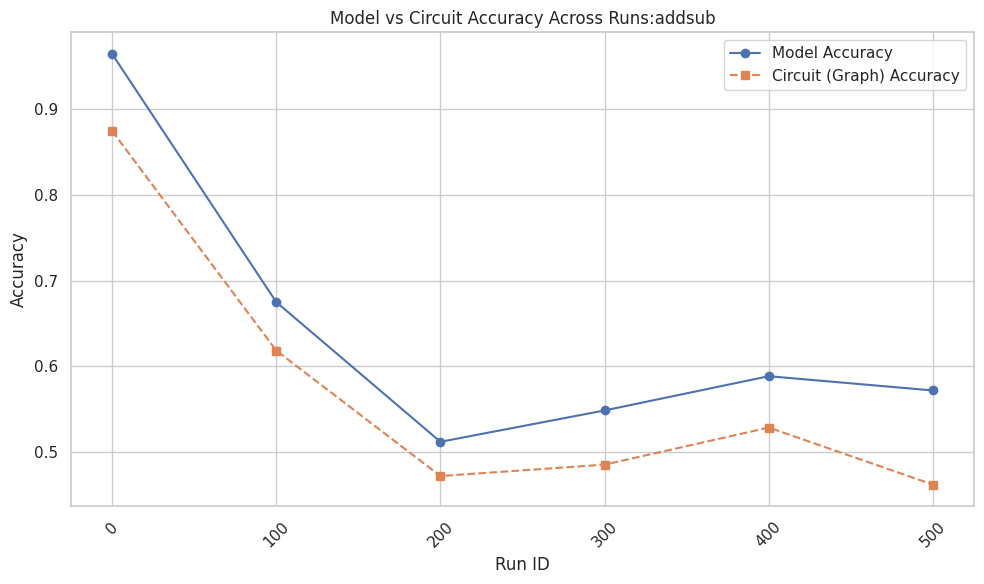

In [13]:
addsub_paths = '../old-fine-tunng/sequential-fine-tuning/experiment_1/circuit_metrics/addsub/metrics'
plot_accuracy(addsub_paths, 'addsub')